In [ ]:
%%capture
%pip install numpy pandas seaborn matplotlib scikit-learn xgboost hyperopt tensorflow

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, random, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from xgboost import XGBClassifier
from hyperopt import fmin, hp, tpe, STATUS_OK

import tensorflow as tf

from src.util import evaluate_model, seed_everything, get_data, build_cnn_model, model_tuner

seed = 42
seed_everything(seed)
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)

2023-11-11 13:56:15.440458: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 13:56:15.440509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 13:56:15.442314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 13:56:15.599221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 13:56:16.721117: W tensorflow/compiler/

# Data inspection & selection

In [3]:
data = pd.read_parquet("data/job_table.parquet")
display(data.head(10))
print(f"Number of rows: {len(data)}")
print(f"Number of columns: {len(data.columns)}")
print(data.columns)

,pn_min_cpus,resize_time,ntasks_per_socket,tres_freq,comment,ntasks_per_socket_str,std_in,array_task_throttle,max_nodes,contiguous,...,cpus_allocated,billable_tres,last_sched_eval,eligible_time,power_flags,cores_per_socket,sockets_per_node,shared,cpus_per_task,req_nodes
0,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n04': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:05+00:00,0,,,OK,4,['r245n04']
1,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r250n19': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:10+00:00,0,,,OK,4,['r250n19']
2,32,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,"{'r212n10': 32, 'r212n15': 32, 'r212n14': 32, ...",256.0,2020-05-22T09:28:37.000Z,2020-05-22 09:28:37+00:00,0,,,OK,1,
3,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r209n15': 4},4.0,2020-05-22T20:39:06.000Z,2020-05-22 01:05:39+00:00,0,,,OK,4,['r209n15']
4,256,1970-01-01 01:00:00+00:00,2.0,,,2,/dev/null,,1,False,...,,,2020-05-22T18:56:39.000Z,2020-05-22 18:56:39+00:00,0,,,OK,32,
5,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n14': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:06+00:00,0,,,OK,4,['r245n14']
6,1,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r226n11': 4},4.0,2020-05-22T10:41:04.000Z,2020-05-22 10:28:50+00:00,0,,,OK,1,['r226n11']
7,1,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n20': 4},4.0,2020-05-22T14:28:26.000Z,2020-05-22 10:29:02+00:00,0,,,OK,1,['r245n20']
8,4,1970-01-01 01:00:00+00:00,1.0,,,1,/dev/null,,0,False,...,{'r239n19': 4},4.0,2020-05-22T16:12:29.000Z,2020-05-22 16:12:28+00:00,0,,,OK,4,
9,128,1970-01-01 01:00:00+00:00,2.0,,,2,/dev/null,,0,False,...,{'r239n20': 128},128.0,2020-05-22T12:15:20.000Z,2020-05-22 12:15:19+00:00,0,,,OK,32,


Number of rows: 6236346
Number of columns: 100
Index(['pn_min_cpus', 'resize_time', 'ntasks_per_socket', 'tres_freq',
       'comment', 'ntasks_per_socket_str', 'std_in', 'array_task_throttle',
       'max_nodes', 'contiguous', 'max_cpus', 'resv_name', 'user_id',
       'tres_per_task', 'derived_ec', 'tres_per_socket', 'exc_nodes',
       'tres_req_str', 'array_job_id', 'boards_per_node', 'priority',
       'num_nodes', 'tres_per_node', 'cpus_alloc_layout', 'name',
       'run_time_str', 'array_task_str', 'time_min', 'time_limit_str',
       'end_time', 'year_month', 'alloc_sid', 'mem_per_cpu', 'req_switch',
       'show_flags', 'group_id', 'wait4switch', 'array_task_id', 'exit_code',
       'mem_per_node', 'restart_cnt', 'requeue', 'tres_bind', 'profile',
       'batch_flag', 'plugin', 'work_dir', 'pn_min_memory', 'nice',
       'ntasks_per_node', 'ntasks_per_core_str', 'accrue_time',
       'tres_alloc_str', 'nodes', 'sockets_per_board', 'std_out',
       'array_max_tasks', 'job_id',

The dataset a huge set of jobs, each with a wide variety of features. Our aim for the project is to build a tool which can prevent a waste of computational time. In HPC center, when we schedule a job execution we have to specify a set of parameters such as the number of cpu, the quantity of memory needed, the time limit, and so on. These parameters are used by the job scheduler to instantiate our work space. It's likely that, because a wrong configuration, a job can fail its run. 

Suppose that for a typo, a programmer specify a wrong amount of required memory, so the job since it does not have enough computational resources, is very likely to fail. It leads to a waste of time and money for the programmer, in these systems company pay a lot of money for the computational resources and the execution queues may be very long. Therefore, a system that predict whether a new job is likely to fail could be very powerfull for both the sides.

To do so, we restict the variety of features to those available at submit time. A possible job's exite state, we only consider the following possibilities: COMPLETED, FAILED, OUT_OF_MEMORY, TIMEOUT. We discard CANCELLED and NODE FAIL states, beacuse they happen for reasons not dependent on the job itself (crash of system partition, highest priority job must run, ecc). 

In order to reduce computational time, we take only a subset of about one sixth of the original.

In [6]:
columns = ["submit_time", "user_id", "group_id", "name", "command", "partition", "priority",
           "qos", "time_limit", "cpus_per_task", 'num_tasks', "tres_req_str", "job_state"]

df = data[columns]
df = df[df.tres_req_str != ""]
df = df[(df.job_state != "CANCELLED") & (df.job_state != "NODE_FAIL")]
df.reset_index(drop=True, inplace=True)
df

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,87034,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,85884,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,115982,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39+00:00,32152,25200,CBC,/m100_scratch/userexternal/squlagha/CaB3C3/job...,m100_usr_prod,80216,normal,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,86934,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016525,2020-10-08 20:31:23+00:00,32588,25200,sire_pjc,/m100_work/hpce3_Tosco/WANG_FULL_OFF_121/RERUN...,m100_usr_prod,297707,normal,720,1,4,"cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1",COMPLETED
1016526,2020-10-09 05:18:51+00:00,31392,25200,praAnt-run4-2m,/m100_work/IscrB_INwARDS_0/NR/NR3/PRant-Run4/r...,m100_usr_prod,145536,normal,1440,32,4,"cpu=128,mem=237.50G,node=1,billing=128,gres/gpu=4",COMPLETED
1016527,2020-10-09 10:20:40+00:00,26429,25200,job_density.sh,/m100_scratch/userexternal/mfarnesi/CP2K_Inter...,m100_usr_prod,917,qos_lowprio,60,32,4,"cpu=128,mem=230000M,node=1,billing=128,gres/gpu=4",FAILED
1016528,2020-10-09 01:36:42+00:00,32232,25200,script.marconi100.x,/m100/home/userexternal/nthomopu/script.marcon...,m100_usr_prod,330946,normal,10,1,8,"cpu=8,mem=7100M,node=1,billing=8,gres/gpu=1",COMPLETED


Inspect the presence of missing values inside our dataset

In [9]:
# in the dataset missing values are empty string, we convert it to nan to count them
df = df.replace('', np.nan)
print(df.isna().sum())
prev_len = len(df)

df = df.dropna().reset_index(drop=True)
print(f"Num of rows: {len(df)}")
print(f"Dropped rows: {prev_len - len(df)} ({(1-(len(df)/prev_len)):.1%})")

submit_time          0
user_id              0
group_id             0
name                 0
command           3584
partition            0
priority             0
qos                  0
time_limit           0
cpus_per_task        0
num_tasks        37945
tres_req_str         0
job_state            0
dtype: int64
Num of rows: 975170
Dropped rows: 41360 (4.1%)


Missing values can leads to error during learning. Indeed, they must be replaced with a default value before being used. This imply, that a classifier can learn associations wiht this values, but it won't correct. Thus, as they are few we decide to drop them. 

At the end, save the dataset for the future usage.

In [15]:
df.to_pickle("data/job_table_reduced.pkl")
del data 
del df

# Data Preprocessing

In [20]:
df =pd.read_pickle("data/job_table_reduced.pkl")
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,87034,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,85884,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,115982,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39+00:00,32152,25200,CBC,/m100_scratch/userexternal/squlagha/CaB3C3/job...,m100_usr_prod,80216,normal,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,86934,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED


As you can see, not all the faetures are numeric, but there are a lot of string data and date. This type of datas don't suit in learning algorithm, so fix it.

Start with those date type, we convert it to a timestamp to have numeric representation of when the job was submitted.

In [21]:
df['submit_time'] = df['submit_time'].apply(lambda x: x.timestamp()).astype(np.int64)

Learning algorithm uses numerica data to infer knowledge, so we need to transform strings into a numeric representation. To do so, in literature exist a large variety of tecniques. Following the Occam's razor, we use the easiest which it consists to convert each string into a number.  

In [22]:
text_columns = ["name", "command", "partition", "qos"]
ord_enc =  OrdinalEncoder(dtype=np.int64)
for col in text_columns:
    val = df[col].values.reshape(-1, 1)
    df[col] = ord_enc.fit_transform(val)
print(f"Text columns transformed: {text_columns}")

df[df.columns[1:-2]] = df[df.columns[1:-2]].apply(pd.to_numeric)

display(df.head())
for col in text_columns:
    print(f"Number of unique values in {col} columns: {len(df[col].unique())}")

Text columns transformed: ['name', 'command', 'partition', 'qos']


,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,1590109565,32171,25200,77949,62668,3,87034,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,1590109570,32171,25200,77949,62782,3,85884,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,1590109539,32171,25200,77949,62085,3,115982,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,1590173799,32152,25200,30918,51406,3,80216,4,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,1590109566,32171,25200,77949,62678,3,86934,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED


Number of unique values in name columns: 78586
Number of unique values in command columns: 238768
Number of unique values in partition columns: 4
Number of unique values in qos columns: 8


Watching the above values, we can say that for **partition** and **qos** columns integer encodig is perfect due their few unique values. For the other 2 instead, it may be the case to find a better way in the feature to improve performance.

Now, for the **tres_req_str** we decide to split this column into 5 different columns: **req_cpu**, **req_mem**, **req_node**, **req_billing**, **req_gpu**. Each column is been filled with the value after the "=" and if not present with a 0. An example of string is and the corresponding splittig is:<br><br>
cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1
| req_cpu | req_mem | req_node | req_billing | req_gpu |
|---------|---------|----------|-------------|---------|
| 256     | 230000  | 1        | 256         | 1       |

In [29]:
labels = df.pop("job_state")

fields = ["req_cpu", "req_mem", "req_node", "req_billing", "req_gpu"]
req_str = df.pop('tres_req_str')
df[fields] = req_str.str.split(',', n=5, expand=True)
for f in fields:
    df[f] = df[f].apply(lambda c: re.sub("[a-zA-Z=/]", "", c) if c is not None else 0)

df[fields] = df[fields].apply(pd.to_numeric)
df["req_mem"] = df["req_mem"].apply(lambda v: round(v, 0)).astype(np.int64)  
    
df["job_state"] = pd.Categorical(list(labels))
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,1590109565,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000,1,4,0,COMPLETED
1,1590109570,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000,1,4,0,COMPLETED
2,1590109539,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000,1,4,0,COMPLETED
3,1590173799,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000,1,256,1,FAILED
4,1590109566,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000,1,4,0,COMPLETED


Save the data for the future.

In [31]:
df.to_pickle("data/job_table_preproc.pkl")
del df

# Data Anlaysis

In [32]:
df = pd.read_pickle("data/job_table_preproc.pkl")
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,1590109565,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000,1,4,0,COMPLETED
1,1590109570,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000,1,4,0,COMPLETED
2,1590109539,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000,1,4,0,COMPLETED
3,1590173799,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000,1,256,1,FAILED
4,1590109566,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000,1,4,0,COMPLETED


Print some data statistics, we exclued user, group info and job name and command beacuse as they are integer encodig of strings their statistics are not relevant

In [33]:
feature_to_describe = ["submit_time", "qos", "time_limit", "cpus_per_task", "num_tasks",
                        "req_cpu", "req_mem", "req_node", "req_billing", "req_gpu"]

df[feature_to_describe].describe().T

,count,mean,std,min,25%,50%,75%,max
submit_time,975170.0,1.597577e+09,4.074300e+06,1.589838e+09,1.592478e+09,1.599163e+09,1.601697e+09,1.602575e+09
qos,975170.0,3.983316e+00,3.737666e-01,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,7.000000e+00
time_limit,975170.0,1.063604e+03,5.112179e+02,1.000000e+00,7.200000e+02,1.440000e+03,1.440000e+03,1.440000e+03
cpus_per_task,975170.0,1.330155e+01,1.625014e+01,1.000000e+00,1.000000e+00,2.000000e+00,3.200000e+01,4.444000e+03
num_tasks,975170.0,1.652385e+01,1.609270e+02,0.000000e+00,4.000000e+00,4.000000e+00,2.400000e+01,3.276800e+04
req_cpu,975170.0,1.148630e+02,6.219569e+02,1.000000e+00,4.000000e+00,2.400000e+01,1.280000e+02,6.553600e+04
req_mem,975170.0,9.824427e+04,5.347606e+05,1.000000e+00,2.380000e+02,8.000000e+03,8.600000e+04,5.796000e+07
req_node,975170.0,1.724648e+00,7.200674e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.560000e+02
req_billing,975170.0,1.148630e+02,6.219569e+02,1.000000e+00,4.000000e+00,2.400000e+01,1.280000e+02,6.553600e+04
req_gpu,975170.0,4.596272e+00,2.751967e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.024000e+03


From the above statistics, we can highlight:
1. data are neither normalized nor standardized
2. *qos* column have values very close to the mean, looking the std
3. half of the job have the maximum time limit
4. all the req features have values very smaller rather than the max, it mean that bigger values are outliers

Now, plot job's exit state statistics
<a id='job_state_dist'></a>

job_state
COMPLETED        0.879829
FAILED           0.101628
TIMEOUT          0.014265
OUT_OF_MEMORY    0.004277
Name: proportion, dtype: float64


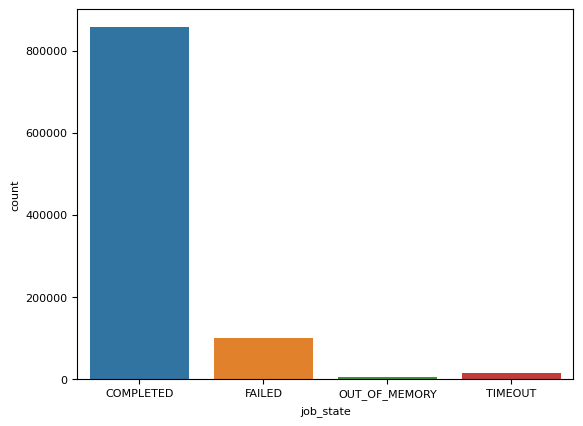

In [54]:
sns.countplot(df, x="job_state", hue="job_state")
print(df.job_state.value_counts(normalize=True))

The dataset is unbulanced. We expected it since we are working with HPC's executed jobs and the presence of many failed would represent a big problem for the company.

Plot the distribution of all dataset's features.

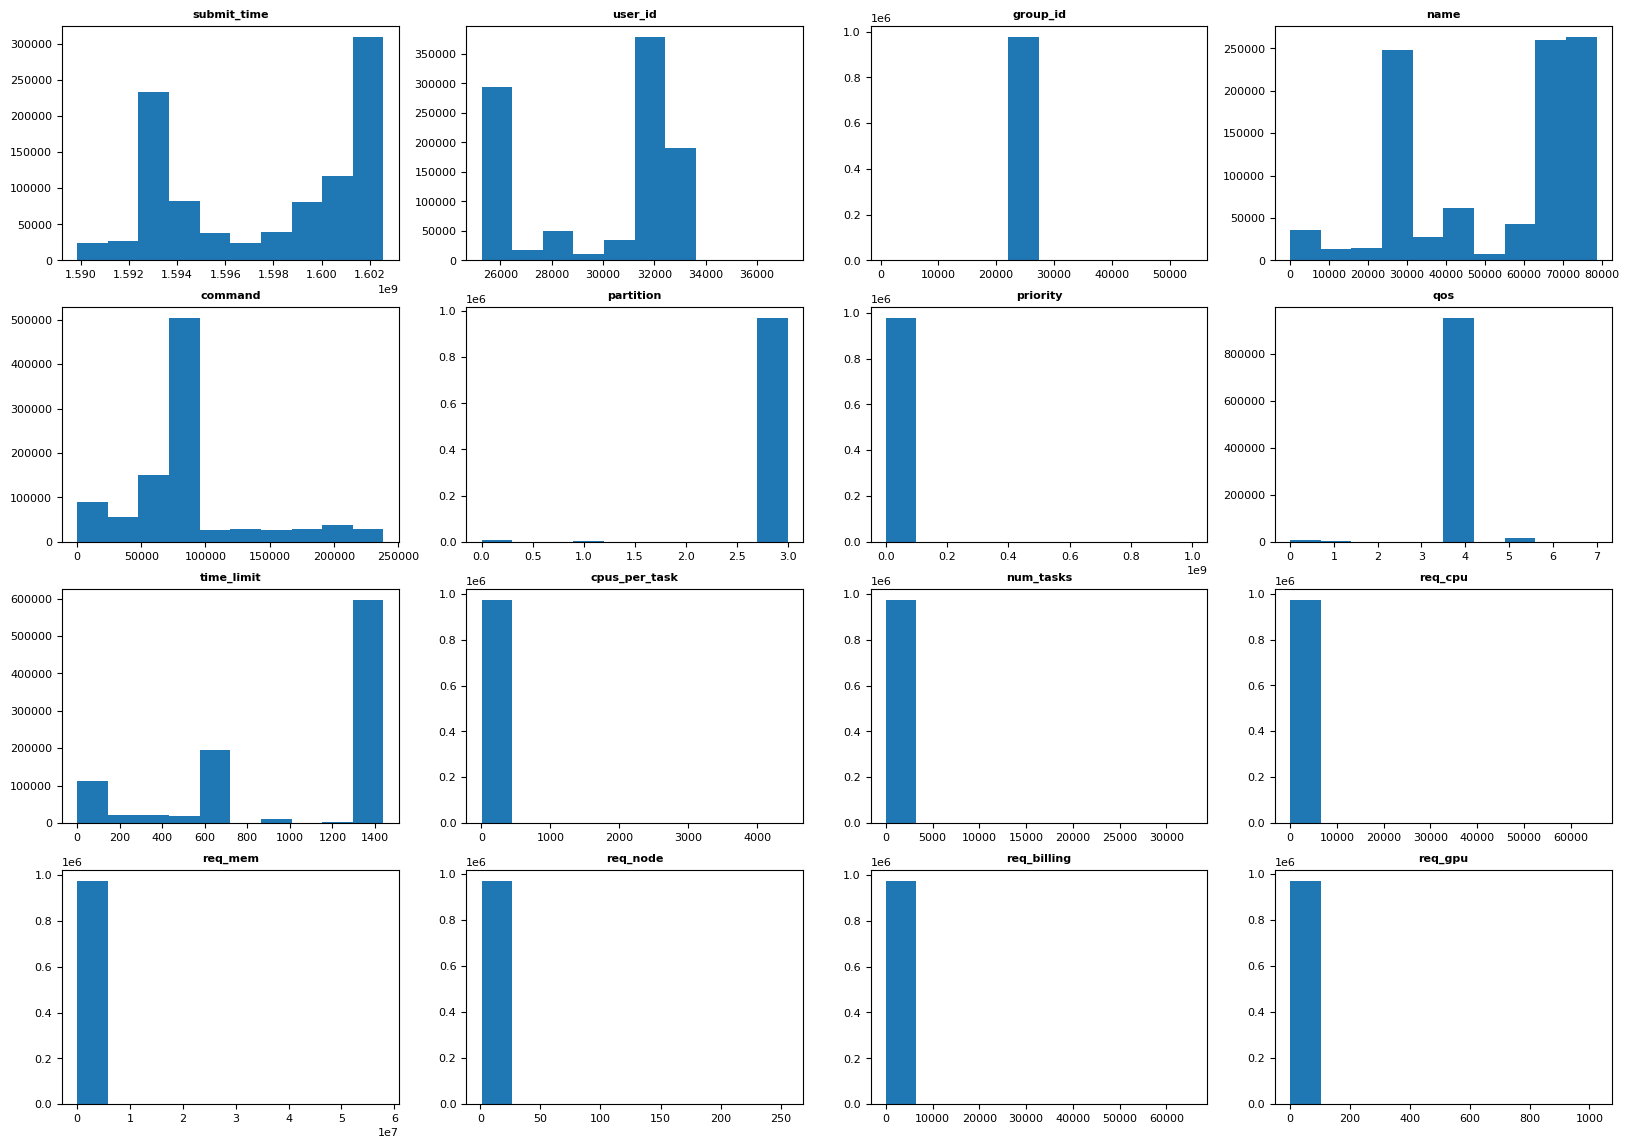

In [55]:
cols = df.select_dtypes(include="int64").columns
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
i, j = 0, 0
for col in cols:
    counts, edges, bars = axs[i, j].hist(df[col])
    axs[i, j].set_title(col, fontweight="bold")
    j+=1
    if j%4 == 0:
        j = 0
        i +=1
plt.show()

There are values that are much more frequent rather than others, this means that outliers are infrequent.

Plot the correlation and try to extract some information on the data.

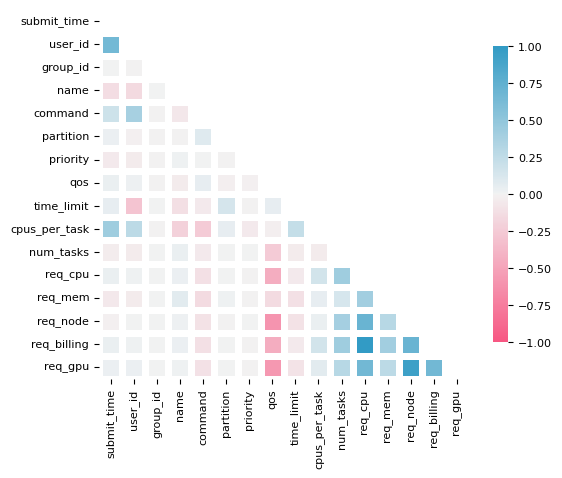

In [56]:
corr_matrix=df.select_dtypes(include=['int64']).corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, square=True, cmap=cmap,
            vmin=-1, vmax=1, linewidths=5, cbar_kws={"shrink": .8})
plt.show()

We saw some patters as: the number of requested cpu is directly proportional to the billing and the node and inversely to the qos. This can be due to the fact that each node has a number of cpus, if you ask for a lot cpus, nodes number increase and simultaneously also the billing. The qos behavior is due to the fact that a job with high number of resources tends to be more affected by premption and rescheduling. In addiction, reading the Slurm documentation, qos parameter spcify also some job's resource limits. It could be the casa that some failed jobs have qos to low and they request to much resources.


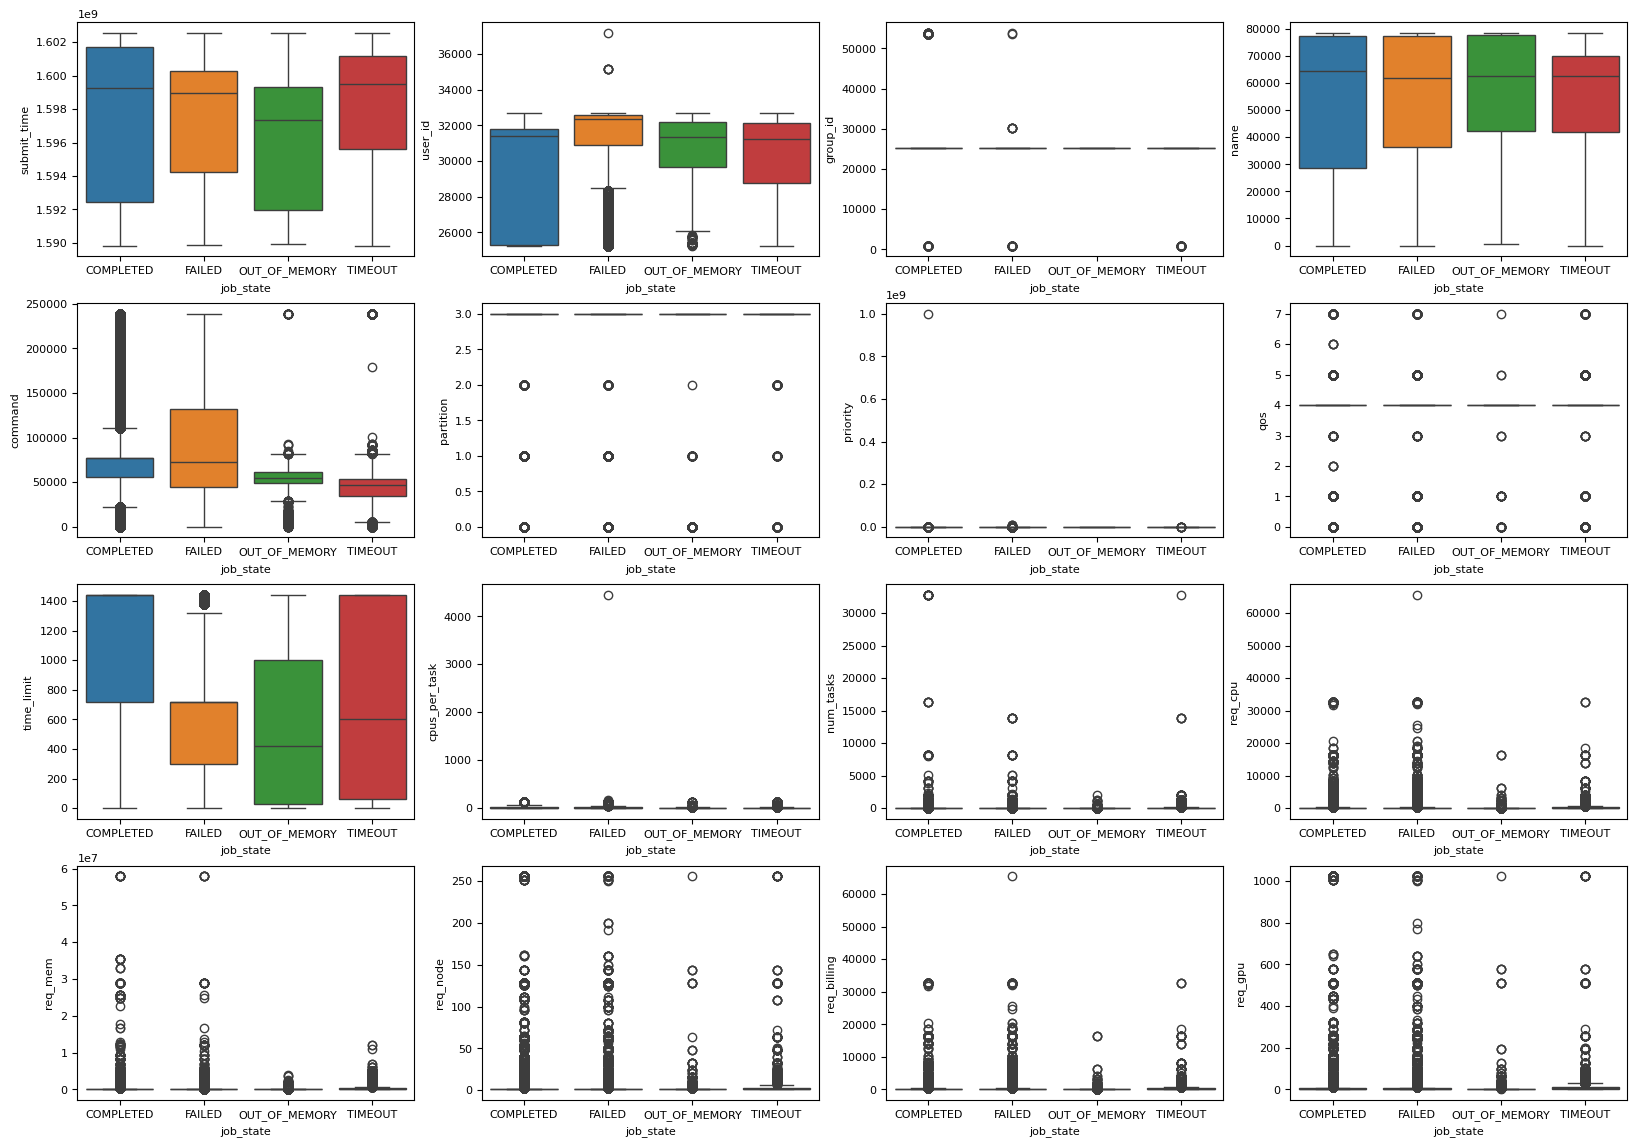

In [53]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))

i, j = 0, 0
for col in df.columns:
    if col != "job_state":
        sns.boxplot(df, x="job_state", y=col, hue="job_state", ax=axs[i, j])
        j+=1
        if j%4 == 0:
            i+=1
            j=0
plt.show()

Looking the plots above, we cannot exctrat any usefull information on which data are distributed among job state possibilities.

# Job Exit State prediction - Binary

Job Exist State is a string which represents that status of a scheduled job. Indeed, once a job is executed, it end in in one of the following 4 possibilities:
1. **COMPLETED**: the execution end correctly
2. **FAILED**: the execution end with a general error. It can be due to several motivations such as error in code, missing I/O, ecc.
3. **OUT OF MEMORY**: the execution is interrupted causes memory saturation
4. **TIME OUT**: the execution time exceed the time limit, so the job's run is interrupted.

Our aim is build an algorithm which can take as input job's parameters and predict its exit state. As first attempt, we focused only on classify whether a job  is completed or not. We firstly binirize our data, converting other fails states into *FAILED*. Secondly, we assign to each job integer label in the following way:
 - **0**: for completed job
 - **1**: for those failed


In [3]:
print("Loading data... ", end="")
data, labels = get_data("data/job_table_preproc.pkl")
print("Lodaded!")
print()
print("Old labels: ", np.unique(labels))

labels[labels == "OUT_OF_MEMORY"] = "FAILED"
labels[labels == "TIMEOUT"] = "FAILED"

print("New labels: ", list(np.unique(labels)))

Loading data... Lodaded!

Old labels:  ['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']
New labels:  ['COMPLETED', 'FAILED']


Encode labels with integer values

In [4]:
lab_enc = {"COMPLETED": 0, "FAILED": 1}

print(f"Old values: {labels[:5]}")
labels = np.asarray([lab_enc[l] for l in labels])
print(f"New values: {labels[:5]}")

Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
New values: [0 0 0 1 0]


Split the data into train and test sets and normalize using only train information

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"train data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"train labels shape: {len(y_train)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 16)
train data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
train labels shape: 546095
test labels shape: 292551


Because of the high imbalance in the dataset, we try to improve performance weighing classes to correct the unbulance

In [6]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = {k:v for k,v in enumerate(class_weight)}
class_weight

{0: 0.5685303444527963, 1: 4.148019019840185}

## Regression

We are working on a binary classification task, so the possibility for a job exit state are only 2: completed or not. The simplest way to address this task is with a regression. **Logistic Regression** is the regression applied when the outcome is bounded betwen 0 and 1. The idea is simply, try to lineraly seprate data points, in the features space. 

Create our regressor and look how it performs.

F1:		train=0.246, validation=0.247
Recall:		train=0.448, validation=0.449
Precision:	train=0.122, validation=0.122


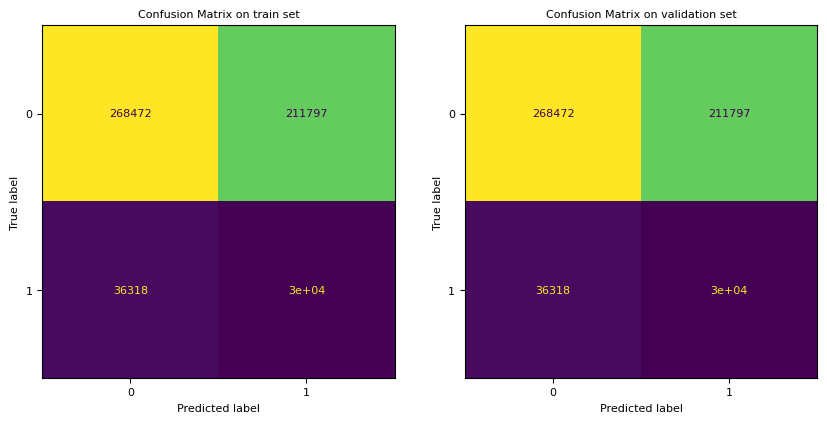

In [26]:
reg = LogisticRegression(class_weight=class_weight, random_state=seed, n_jobs=-1)
reg.fit(x_train, y_train)
evaluate_model(reg, x_train, y_train, x_val, y_val)

Very bad performance. Data points are not separable. Therefore, we decide to not tune the model.

## Classification

### Decision Tree

We are working with tabular data and with this type of data the relation between features is very important. One of the simplest but powerfull classification tools are so called CART algorithms. **Decision Trees** is one of them. It's very powerfull for many reason including speed, explainability, reliability, simplicity it become a milestone for Machine Learning. They work building a decision tree from the root to the leaf, where each leaf is an output class value.

Let's how its perform on our data

F1:		train=0.930, validation=0.828
Recall:		train=0.986, validation=0.869
Precision:	train=0.826, validation=0.747


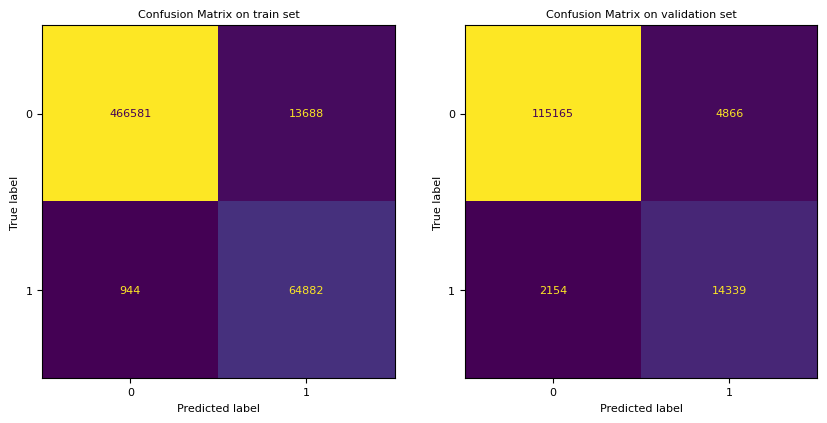

In [69]:
dt_bin = DecisionTreeClassifier(class_weight=class_weight, random_state = seed)
dt_bin = dt_bin.fit(x_train, y_train)
evaluate_model(dt_bin, x_train, y_train, x_val, y_val)

Preatty good results on the validation set. However, there is a big gap between the train and validation performance and the classifier lost around 10%. By looking Precision and Recall score, you can notice that it tends to classify a job as failed when uncertain.

Now, tune the Decision Tree depth and try to reduce overfitting. We use a random serach over all the possible parameters configuration trying to increase both the F1 and the Recall. In this case the second is very important because minimizing the false negative bring more reliable system.

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [03:50<00:00,  2.33s/it]


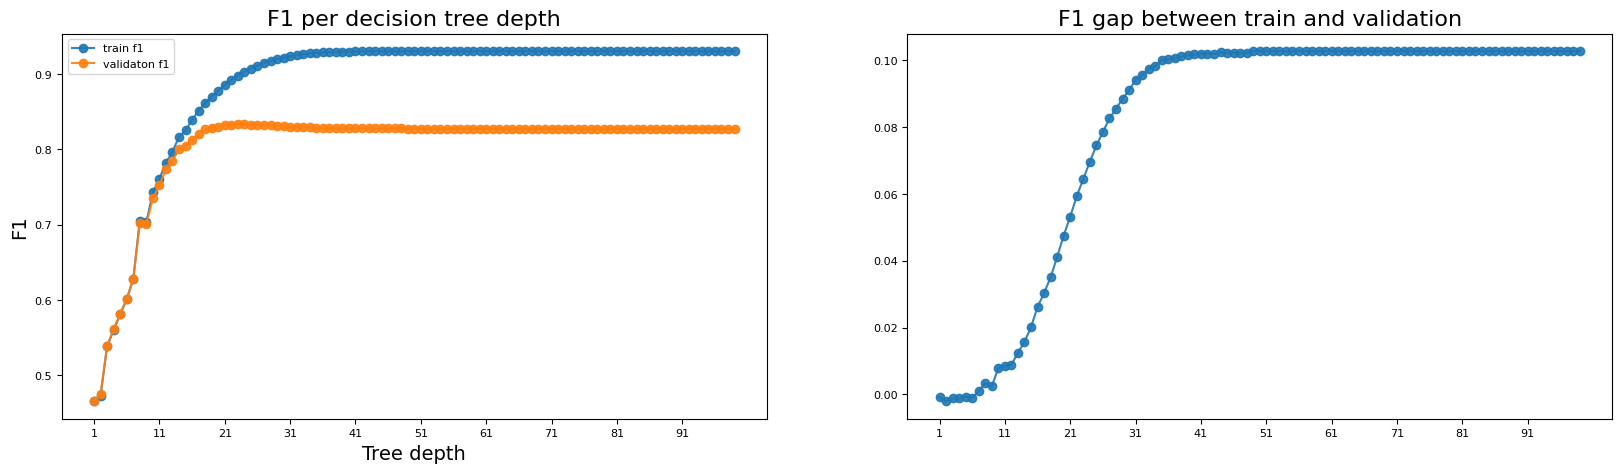

In [73]:
# # # fitting trees of depth 1 to 24
depths = range(1,100)
models = [DecisionTreeClassifier(max_depth=d, class_weight=class_weight, random_state=seed) for d in depths]

train_scores, val_scores, err_f1 = model_tuner(models, x_train, y_train, x_val, y_val, fbeta_score)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(depths, train_scores, '-o', label='train f1', alpha=0.9)
ax1.plot(depths, val_scores, '-o', label='validaton f1', alpha=0.9)
ax1.set_title('F1 per decision tree depth', fontsize=16)
ax1.set_xlabel('Tree depth', fontsize=14)
ax1.set_ylabel('F1', fontsize=14)
ax1.set_xticks(range(1, 100, 10))

ax2.plot(depths, err_f1, '-o', alpha=0.9)
ax2.set_title('F1 gap between train and validation', fontsize=16)
ax2.set_xticks(range(1, 100, 10))
ax1.legend()
plt.show()

Looking the above graph we saw an interesting pattern, the validation f1 score increase till reached a value near 20 and after it start to decrease. This highlights that the model start to overfit. The error graph shows near those values we have a relatively small difference between the train and validation score, while with a bigger values it increases. Therefore, we chose ha maximum depth that values that maximize the validation score.

F1:		train=0.892, validation=0.833
Recall:		train=0.983, validation=0.916
Precision:	train=0.739, validation=0.692


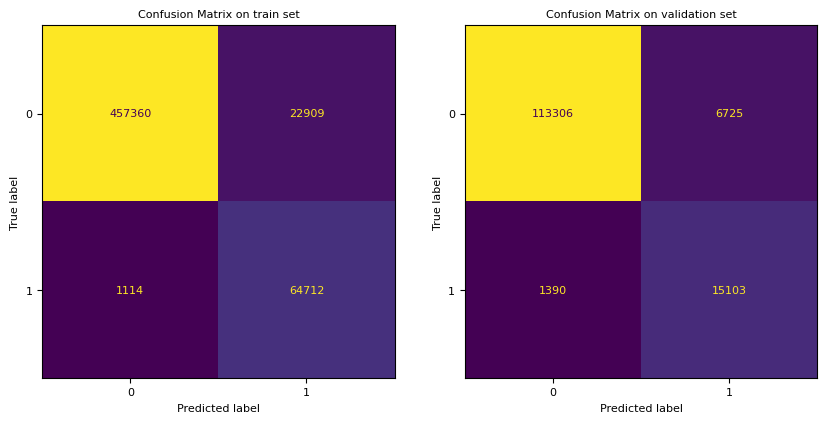

In [83]:
depths = min(depths) + np.argmax(val_scores)

dt_bin_tuned = DecisionTreeClassifier(max_depth=depths,
                                      class_weight=class_weight,
                                      random_state = seed)
dt_bin_tuned = dt_bin_tuned.fit(x_train, y_train)
evaluate_model(dt_bin_tuned, x_train, y_train, x_val, y_val)

Comparing this results with the initial, we increased performance very little, we just move 5% of the precision score to the recall. This means that the classifier just tend to predict more times fail rather than completed. In out scenario, this coul be acceptable beacuse, it's more costly classify completed a job which it will fails, rather than the opposite. 

### Random Forest


In the field of machine learning, **ensemble methods** are used to combine base estimators (i.e. weak learners). Two types of ensemble methods are averaging (eg. bagging) and boosting (eg. gradient boosting). Ensemble methods not only increase the performance but also reduce the risk of overfitting. We start using the bagging one, expecially the **Random Forest**.

It consists of a large number of individual Decision Trees, where at the end the predictions of the learners are aggregated. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction.

Training time: 14.4 seconds
F1:		train=0.923, validation=0.841
Recall:		train=0.980, validation=0.888
Precision:	train=0.815, validation=0.752


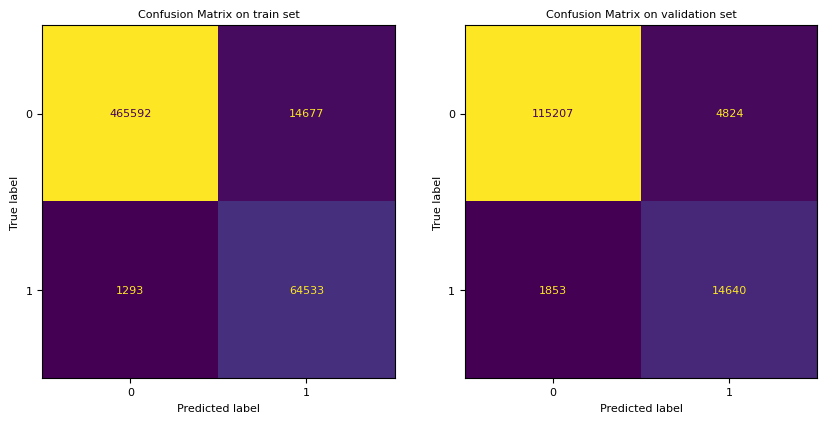

In [27]:
rf_bin = RandomForestClassifier(class_weight=class_weight, random_state=seed, n_jobs=-1)
start_time = time.time()
rf_bin.fit(x_train, y_train)
rf_train_time = time.time() - start_time
print(f"Training time: {rf_train_time:.1f} seconds")
evaluate_model(rf_bin, x_train, y_train, x_val, y_val)

As we expected, we obtain sligthy better results. This it's justified by the more complexity of the Random Forest algorithm wrt the standard Decision Tree. Again, looking the gap between the train and the validation performances, we can say that the algorithm overfit, slightly less than DT, on training data. For this fact, we try to reduce this fact with the tuning.

Beeing the Random Forest a set of Decision Trees, we have to tune the maximum depth they can reach.

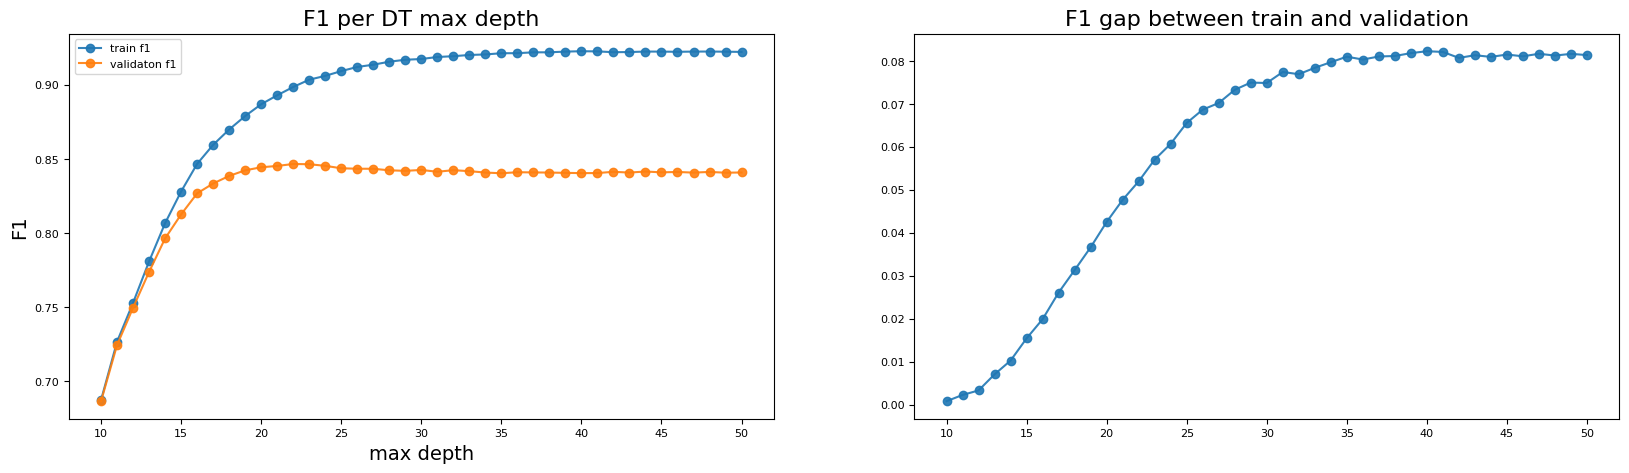

In [11]:
estimators =  range(100,151)
models = [RandomForestClassifier(n_estimators=n, class_weight=class_weight, random_state=seed, n_jobs=-1) for n in estimators]

train_scores, val_scores, err_f1 = model_tuner(models, x_train, y_train, x_val, y_val, fbeta_score)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(estimators, train_scores, '-o', label='train f1', alpha=0.9)
ax1.plot(estimators, val_scores, '-o', label='validaton f1', alpha=0.9)
ax1.set_title('F1 per DT max depth', fontsize=16)
ax1.set_xlabel('max depth', fontsize=14)
ax1.set_ylabel('F1', fontsize=14)
ax1.set_xticks(range(min(estimators), max(estimators)+1, 5))

ax2.plot(estimators, err_f1, '-o', alpha=0.9)
ax2.set_title('F1 gap between train and validation', fontsize=16)
ax2.set_xticks(range(min(estimators), max(estimators)+1, 5))
ax1.legend()
plt.show()

Same behavior like the standard Decision Tree. As always chose as max depth that value that maximize the validation score. 

Max depth: 22
Training time: 14.2 seconds
F1:		train=0.923, validation=0.841
Recall:		train=0.980, validation=0.888
Precision:	train=0.815, validation=0.752


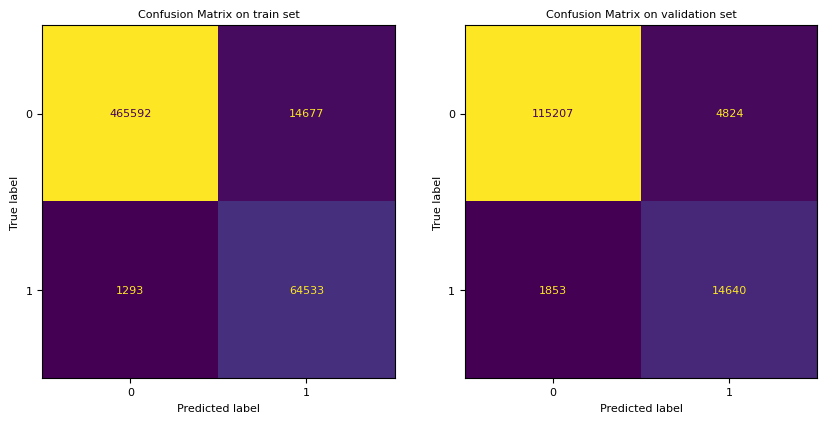

In [26]:
max_depth_rf = min(depths) + np.argmax(val_scores)
print(f"Max depth: {max_depth_rf}")

rf_bin_tuned = RandomForestClassifier(max_depth=max_depth_rf,
                                      class_weight=class_weight,
                                      random_state=seed,
                                      n_jobs=-1)
start_time = time.time()
rf_bin_tuned.fit(x_train, y_train)
rf_train_time = time.time() - start_time
print(f"Training time: {rf_train_time:.1f} seconds")
evaluate_model(rf_bin, x_train, y_train, x_val, y_val)

### Gradient Boosting


The last algorithm class tested is the **Gradient Booosting**. In particulare we use the **XGBoost**, that is a open-source implementation of the gradient boosted trees algorithm. It is so called for the uses of Decision Trees as weak classifiers and the gradient descent as loss function optimizer.

F1:		0.740
Recall:		0.696
Precision:	0.859


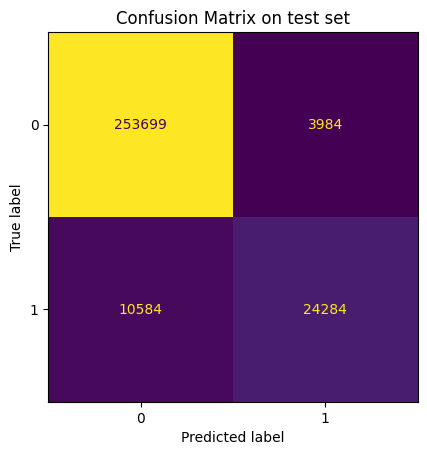

In [27]:
xgb_bin = XGBClassifier(objective='binary:logistic',
                        booster='gbtree',
                        random_state=seed,
                        n_jobs = -1,
)
xgb_bin.fit(x_train, y_train)
evaluate_model(xgb_bin, x_test, y_test)

In [78]:
def xgb_objective(search_space):
    model = XGBClassifier(objective='binary:logistic',
                         booster='gbtree',
                         scale_pos_weight=class_weight[1],
                         random_state=seed,
                         n_jobs = -1,
                         **search_space
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.5, average="binary")
    return {'loss': -f_beta, 'status': STATUS_OK}

# xgb_search_space={'max_depth': hp.randint("max_depth", 3, 100),
#                   'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       
#         'n_estimators': 180,
#         'seed': 42
#     }

xgb_search_space={'max_depth': 86,
                  'min_child_weight' : 7,
                  'subsample': hp.quniform('subsample', 0, 1),
                  'colsample_bytree' : hp.quniform('colsample_bytree', 0, 10, 1),
                  'learning_rate': 0.1,
}

In [80]:
xgb_best_params = fmin(
  fn=xgb_objective,
  space=xgb_search_space,
  algo=tpe.suggest,
  max_evals=100)

print("Best param XGBoost (binary):")
print(xgb_best_params)

100%|██████████| 100/100 [14:11<00:00,  8.51s/trial, best loss: -0.8264974557047392]
Best param XGBoost (binary):
{'max_depth': 86, 'min_child_weight': 7.0}


F1:
 - train set:		0.865
 - validation set:	0.824
Recall:
 - train set:		0.980
 - validation set:	0.931
Precision:
 - train set:		0.684
 - validation set:	0.655


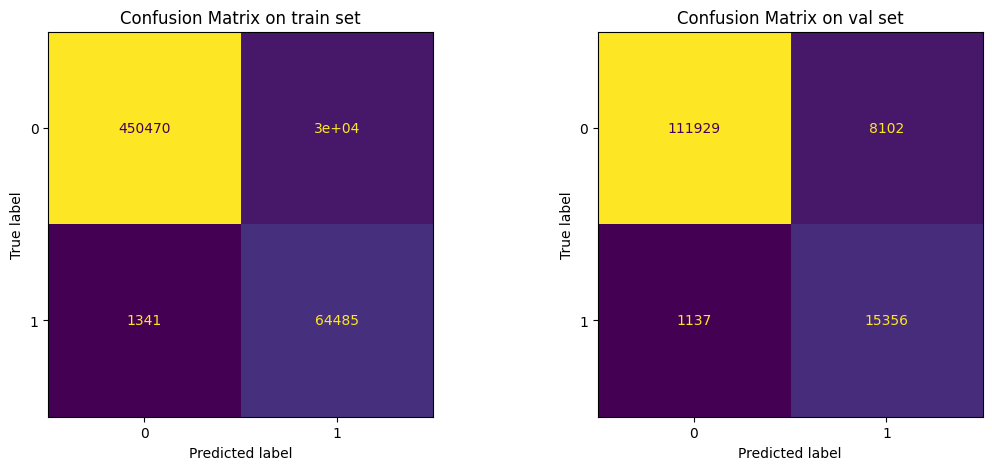

In [81]:
xgb_bin_tuned = XGBClassifier(objective='binary:logistic',
                        booster='gbtree',
                        scale_pos_weight=class_weight[1],
                        random_state=seed,
                        n_jobs = -1,
                        **xgb_best_params
)
xgb_bin_tuned.fit(x_train, y_train)
evaluate_model(xgb_bin_tuned, x_train, x_val, y_train, y_val)

### Stacking Ensemble

F1:
 - train set:		0.960
 - validation set:	0.843
Recall:
 - train set:		0.968
 - validation set:	0.842
Precision:
 - train set:		0.942
 - validation set:	0.846


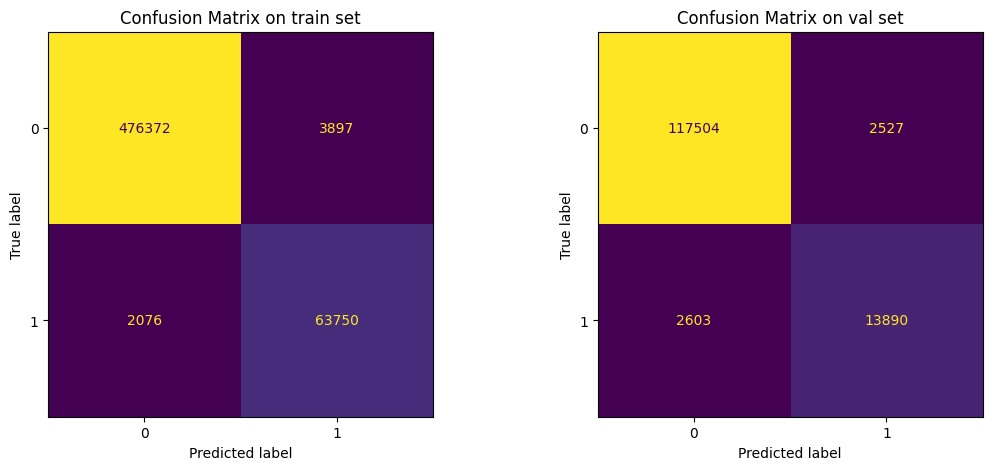

In [62]:
from sklearn.ensemble import StackingClassifier

models = [
    ('rf', RandomForestClassifier(class_weight=class_weight, random_state=seed, n_jobs=-1)),
    ('xgb', XGBClassifier(objective='binary:logistic', booster='gbtree', random_state=seed, n_jobs=-1, max_depth=86, min_child_weight=7.0, scale_pos_weight=class_weight[1]))
]
clf = StackingClassifier(estimators = models, final_estimator=LogisticRegression(), n_jobs=-1)
clf.fit(x_train, y_train)
evaluate_model(clf, x_train, x_val, y_train, y_val)

### Neural Networks

In [7]:
nn_model_bin = build_cnn_model((x_train.shape[1],1,), 1, 3, 2)
nn_model_bin.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 128)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 256)            98560     
                                                                 
 conv1d_3 (Conv1D)           (None, 8, 256)            196864    
                                                             

2023-11-08 12:25:43.621135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9910 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
nn_model_bin.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     loss_weights=list(class_weight.values()),
                     metrics=tf.keras.metrics.BinaryAccuracy())
history = nn_model_bin.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), validation_batch_size=1024, callbacks=[callback])

Epoch 1/100


2023-11-08 12:25:47.856135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8901
2023-11-08 12:25:49.597793: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f21d017dc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 12:25:49.597817: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-11-08 12:25:49.602528: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 12:25:49.701571: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1067/1067 [==============================] - 18s 12ms/step - loss: 0.3454 - binary_accuracy: 0.8800 - val_loss: 0.3041 - val_binary_accuracy: 0.8846
Epoch 2/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2751 - binary_accuracy: 0.8903 - val_loss: 0.2654 - val_binary_accuracy: 0.8926
Epoch 3/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2539 - binary_accuracy: 0.8958 - val_loss: 0.2427 - val_binary_accuracy: 0.8986
Epoch 4/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2422 - binary_accuracy: 0.8999 - val_loss: 0.2331 - val_binary_accuracy: 0.9022
Epoch 5/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2339 - binary_accuracy: 0.9037 - val_loss: 0.2272 - val_binary_accuracy: 0.9074
Epoch 6/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2279 - binary_accuracy: 0.9060 - val_loss: 0.2270 - val_binary_accuracy: 0.9047
Epoch 7/100
1067/1067 [=======================

In [9]:
pred_train = nn_model_bin.predict(x_train, batch_size=512)
pred_val = nn_model_bin.predict(x_val, batch_size=512)
pred_train = pred_train.reshape(pred_train.shape[0])
pred_val = pred_val.reshape(pred_val.shape[0])
pred_train = np.where(pred_train >= 0.5, 1, 0)
pred_val = np.where(pred_val >= 0.5, 1, 0)

267/267 [==============================] - 1s 3ms/step


F1:
 - train set:		0.662
 - validation set:	0.651
Recall:
 - train set:		0.621
 - validation set:	0.609
Precision:
 - train set:		0.780
 - validation set:	0.770


<function matplotlib.pyplot.show(close=None, block=None)>

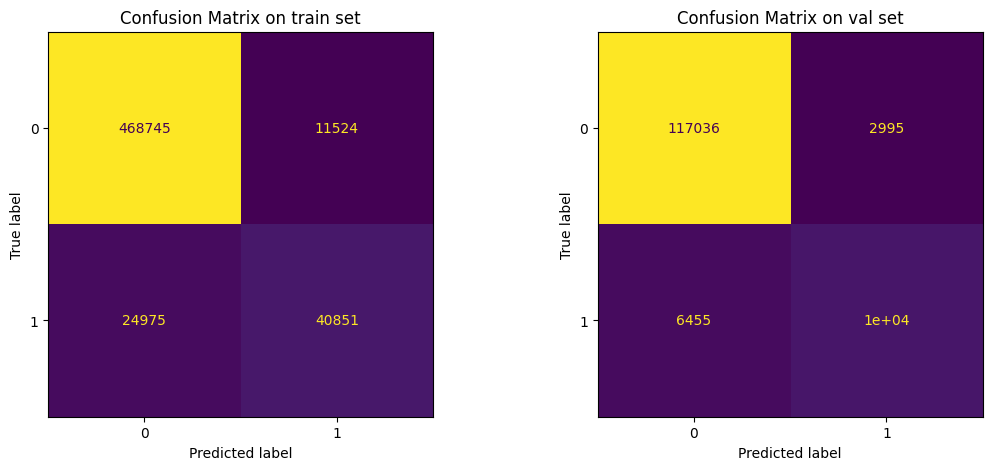

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support


t_precision, t_recall, t_f1, _ = precision_recall_fscore_support(y_train, pred_train, beta=1.5, average="binary")
v_precision, v_recall, v_f1, _ = precision_recall_fscore_support(y_val, pred_val, beta=1.5, average="binary")
print(f"F1:\n - train set:\t\t{t_f1:.3f}\n - validation set:\t{v_f1:.3f}")
print(f"Recall:\n - train set:\t\t{t_recall:.3f}\n - validation set:\t{v_recall:.3f}")
print(f"Precision:\n - train set:\t\t{t_precision:.3f}\n - validation set:\t{v_precision:.3f}")

train_cm = confusion_matrix(y_train, pred_train)
val_cm = confusion_matrix(y_val, pred_val)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(ax=ax1, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=val_cm).plot(ax=ax2,  colorbar=False)
ax1.set_title("Confusion Matrix on train set")
ax2.set_title("Confusion Matrix on val set")
plt.show

# Job Exit State prediction - Multiclass
Once completed the binary task, we extend it to the multiclass one. Indeed, inside the dataset failed job could in three status:
1. **FAILED**: the job contains an error end it fails
2. **OUT OF MEMORY**: the job exceed its memory limit and it has been terminated
3. **TIMEOUT**: as for the previus, terminated beacuse exeeded the time limit



In [3]:
print("Loading data... ", end="")
data, labels = get_data("data/job_table_preproc.pkl")
print("Lodaded!")
print("Labels:", np.unique(labels))

Loading data... Lodaded!
Labels: ['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']


In [4]:
lab_enc_mc = LabelEncoder()
print(f"Old values: {labels[:5]}")
labels = lab_enc_mc.fit_transform(labels)
print(f"Old values: {labels[:5]}")

Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
Old values: [0 0 0 1 0]


Split the data into train, validation and test sets and normalize using only train information

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 16)
val data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


As mentioned in this [plot]{#job_state_dist} in data analisys, data are heavly unbalanced. Let's assign to each class a weight proportional to the inverse of its frequence in the train split

In [6]:
total = len(y_train)
lbl_freq = np.bincount(y_train)
class_weight_mc = {k:1/(freq/total) for k,freq in enumerate(lbl_freq)}
class_weight_mc

{0: 1.1370606889055925,
 1: 9.808445290609958,
 2: 232.67788666382614,
 3: 69.98526207868768}

## Decision Tree
As before, start with the easiest classifier and use the trees to infer knowledge on our data.

F1:
 - train set:		0.954
 - validation set:	0.784
Recall:
 - train set:		0.989
 - validation set:	0.804
Precision:
 - train set:		0.891
 - validation set:	0.748


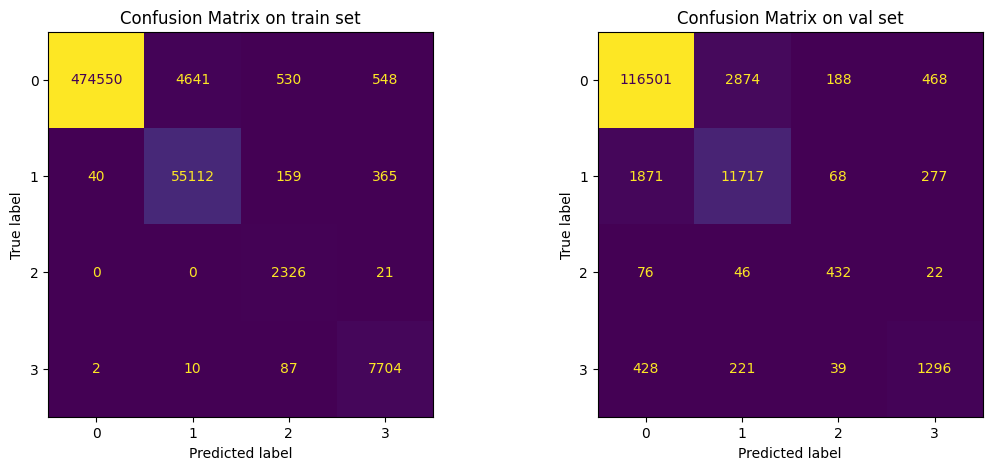

In [19]:
dt_clf_mc = DecisionTreeClassifier(class_weight=class_weight_mc, random_state = seed)
dt_clf_mc = dt_clf_mc.fit(x_train, y_train)
evaluate_model(dt_clf_mc, x_train, x_val, y_train, y_val, average="macro")

This results are still encouraging. Indeed, with basic setup we saw a quiet good score in terms of F1 and Recall on validation set. The big gap between train and validation performance highlights the overfitting. This means that hyperparameters such as reducing the depth of the trees help the classifier to better abstract the data. All in all, we lost less than 10% point from the binary case, so we are satisfied with the results.

Now, let's tune some parameters to increase the perfomance.

In [ ]:
def dt_mc_objective(search_space):
    model = DecisionTreeClassifier(class_weight=class_weight, random_state = seed, **search_space)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.2, average="binary")
    return {'f_beta': -f_beta, 'status': STATUS_OK}

dt__mc_search_space={'max_depth': hp.randint('max_depth',50,100),
                     'min_samples_split': hp.randint('min_samples_split',1,40),
                     'min_samples_leaf':hp.randint('min_samples_leaf',1,20),
                     'max_features':hp.choice('max_features',[None, 'sqrt', 'log2']) 
}

dt_mc_best_params = fmin(
  fn=dt_mc_objective,
  space=dt__mc_search_space,
  algo=tpe.suggest,
  max_evals=100)

print("Best param for Decision Tree (multiclass):")
print(dt_mc_best_params)

In [ ]:
dt_clf_mc_tuned = DecisionTreeClassifier(class_weight=class_weight, random_state = seed, **dt_mc_best_params)
dt_clf_mc_tuned = dt_clf_mc_tuned.fit(x_train, y_train)
evaluate_model(dt_clf_mc_tuned, x_train, x_val, y_train, y_val, average="macro")

## Ensamble Classifier

In [33]:
rf_mc_clf = RandomForestClassifier(class_weight=class_weight_mc, random_state=seed)
rf_mc_clf.fit(x_train, y_train)
evaluate_model(rf_mc_clf, x_train, x_val, y_train, y_val, average="macro")

RandomForestClassifier(class_weight={0: 1.1370606889055925,
                                     1: 9.808445290609958,
                                     2: 232.67788666382614,
                                     3: 69.98526207868768},
                       random_state=42)

There results are very much in line with those of the Decision Tree. Tune it in order to increase the performance a bit.

In [ ]:
def rf_mc_objective(search_space):
    model = RandomForestClassifier(class_weight=class_weight_mc, random_state=seed, **search_space)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.2, average="binary")
    return {'f_beta': -f_beta, 'status': STATUS_OK}

rf__mc_search_space={'max_depth': hp.randint('max_depth',50,100),
                     'min_samples_split': hp.randint('min_samples_split',1,40),
                     'min_samples_leaf':hp.randint('min_samples_leaf',1,20),
                     'max_features':hp.choice('max_features',[None, 'sqrt', 'log2']) 
}

rf_mc_best_params = fmin(
  fn=rf_mc_objective,
  space=rf__mc_search_space,
  algo=tpe.suggest,
  max_evals=100)

print("Best param for Random Forest (multiclass):")
print(rf_mc_best_params)

In [ ]:
rf_mc_tuned = RandomForestClassifier(class_weight=class_weight, random_state = seed, **rf_mc_best_params)
rf_mc_tuned = rf_mc_tuned.fit(x_train, y_train)
evaluate_model(rf_mc_tuned, x_train, x_val, y_train, y_val, average="macro")

Comment on tuned results

And as did before, we try also the Gradient Boosting algorithm, in particulat **XGBoost**.

F1:
 - train set:		0.763
 - validation set:	0.741
Recall:
 - train set:		0.730
 - validation set:	0.709
Precision:
 - train set:		0.862
 - validation set:	0.840


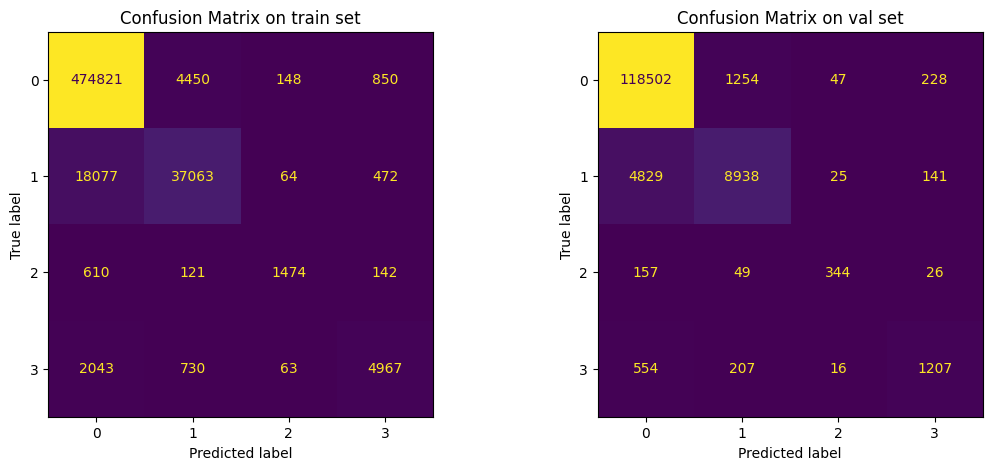

In [11]:
xgb_mc = XGBClassifier(objective='multi:softmax',
                        booster='gbtree',
                        random_state=seed,
                        n_jobs = -1,
)
xgb_mc.fit(x_train, y_train)
evaluate_model(xgb_mc, x_train, x_val, y_train, y_val, average="macro")

As always, tune the classifier

In [ ]:
def xgb_mc_objective(search_space):
    model = XGBClassifier(objective='multi:softmax',
                          booster='gbtree',
                          random_state=seed,
                          n_jobs = -1,
                          **search_space
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.5, average="binary")
    return {'f_beta': -f_beta, 'status': STATUS_OK}

xgb__mc_search_space={'max_depth': hp.randint('max_depth',50,100),
                     'min_samples_split': hp.randint('min_samples_split',1,40),
                     'min_samples_leaf':hp.randint('min_samples_leaf',1,20),
                     'max_features':hp.choice('max_features',[None, 'sqrt', 'log2']) 
}

xgb_mc_best_params = fmin(
  fn=xgb_mc_objective,
  space=xgb__mc_search_space,
  algo=tpe.suggest,
  max_evals=100)

print("Best param for XGBoost (multiclass):")
print(xgb_mc_best_params)

In [ ]:
xgb_mc_tuned = XGBClassifier(objective='multi:softmax',
                             booster='gbtree',
                             random_state=seed,
                             n_jobs = -1,
                             **xgb_mc_best_params
)
xgb_mc_tuned = xgb_mc_tuned.fit(x_train, y_train)
evaluate_model(xgb_mc_tuned, x_train, x_val, y_train, y_val, average="macro")

## Ensemble of Ensembles

In [7]:
train_labels = []
for lbl in range(4):
    train_labels.append([int(y_train[i] == lbl) for i in range(len(y_train))])

In [9]:
classes_freq = [np.bincount(train_labels[i]) for i in range(4)]
weights = [{k:1/(freq/total) for k,freq in enumerate(classes_freq[i])} for i in range(4)]
weights[0] = {0:1, 1:1}
weights

[{0: 1, 1: 1},
 {0: 1.1135274122739942, 1: 9.808445290609958},
 {0: 1.004316337715265, 1: 232.67788666382614},
 {0: 1.0144958498361483, 1: 69.98526207868768}]

In [10]:
rf_bin_task = [RandomForestClassifier(class_weight=weights[i], random_state=seed) for i in range(4)]
for i in range(4):
    rf_bin_task[i].fit(x_train, train_labels[i])

In [23]:
preds = []
for i in range(4):
    pred = rf_bin_task[i].predict_proba(x_val)
    preds.append(pred)
preds = np.asarray(preds).T
preds

In [22]:
from sklearn.metrics import precision_recall_fscore_support

final_pred = np.argmax(preds, axis=1)
prec, rec, f1, _ = precision_recall_fscore_support(y_val, final_pred, beta=1.5, average="macro")
print(f"F1:\t\t{f1:.3f}")
print(f"Recall:\t\t{rec:.3f}")
print(f"Precision:\t{prec:.3f}")

F1:		0.802
Recall:		0.804
Precision:	0.802


In [24]:
preds = []
for i in range(4):
    pred = rf_bin_task[i].predict(x_val)
    preds.append(pred)
preds = np.asarray(preds).T

In [34]:
preds

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [ ]:
final_pred = []
for x,pred in zip(x_val, preds):
    one_idx = np.where(pred == 1)[0]
    if len(one_idx) > 1 or  len(one_idx) == 0:
        final_pred.append(rf_mc_clf.predict([x])[0])
    else:
        final_pred.append(one_idx[0])
final_pred   

In [47]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, _ = precision_recall_fscore_support(y_val, final_pred, beta=1.5, average="macro")
print(f"F1:\t\t{f1:.3f}")
print(f"Recall:\t\t{rec:.3f}")
print(f"Precision:\t{prec:.3f}")

F1:		0.796
Recall:		0.807
Precision:	0.775
